In [ ]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import mse
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

In [3]:
base_vars = pd.read_csv("base_variables.csv.gz")
base_vars

,id,eom,excntry,gvkey,permno,prc_local,ret_exc,ret_exc_lead1m,me,be_me,ope_be,at_gr1,ret_3_1
0,10000.0,1986-01-31,USA,13007.0,10000.0,4.375000,NaN,-0.262439,16.100000,NaN,NaN,NaN,NaN
1,10000.0,1986-02-28,USA,13007.0,10000.0,3.250000,-0.262439,0.359422,11.960000,NaN,NaN,NaN,NaN
2,10000.0,1986-03-31,USA,13007.0,10000.0,4.437500,0.359422,-0.103933,16.330000,NaN,NaN,NaN,-0.257143
3,10000.0,1986-04-30,USA,13007.0,10000.0,4.000000,-0.103933,-0.227590,15.172000,NaN,NaN,NaN,0.014286
4,10000.0,1986-05-31,USA,13007.0,10000.0,3.109375,-0.227590,-0.010271,11.793859,0.058420,-0.763425,NaN,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784833,135628901.0,2024-01-31,USA,356289.0,NaN,6.355000,NaN,NaN,170.676235,0.082321,-0.120398,NaN,NaN
2784834,135628901.0,2024-02-29,USA,356289.0,NaN,5.000000,NaN,NaN,134.285000,0.104630,-0.120398,NaN,NaN
2784835,135628901.0,2024-03-31,USA,356289.0,NaN,5.290000,NaN,NaN,143.549440,0.097878,-0.120398,NaN,NaN
2784836,135628901.0,2025-01-31,USA,356289.0,NaN,2.720000,NaN,NaN,84.325440,0.536583,-0.009943,5.006107,NaN


In [4]:
macro_vars = pd.read_csv("macro_variables.csv.gz")
macro_vars

,date,FEDFUNDS,T10Y2Y,BAA10Y,VIXCLS,INDPRO
0,1985-01-31,8.35,1.27,NaN,NaN,NaN
1,1985-02-28,8.50,1.25,NaN,NaN,NaN
2,1985-03-31,8.58,1.22,NaN,NaN,0.002936
3,1985-04-30,8.27,1.50,NaN,NaN,0.001467
4,1985-05-31,7.97,1.36,NaN,NaN,-0.002202
...,...,...,...,...,...,...
486,2025-07-31,4.33,0.43,1.67,16.72,0.005349
487,2025-08-31,4.33,0.64,1.80,15.36,-0.003763
488,2025-09-30,4.22,0.56,1.67,16.28,0.000972
489,2025-10-31,4.09,0.51,1.69,17.44,NaN


In [114]:
## Fama French portfolios - for market return and model risk-factor decomposition (if wanted)
FF_portfolios = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", skiprows = 4, nrows=747)
FF_portfolios['date'] = pd.to_datetime(FF_portfolios['date'].astype(str), format='%Y%m')
FF_portfolios['date'] = FF_portfolios['date'].dt.to_period('M').dt.to_timestamp('M').dt.strftime('%Y-%m-%d')
FF_portfolios['date'] = pd.to_datetime(FF_portfolios['date'])
FF_portfolios['mkt_exc'] = FF_portfolios['Mkt-RF']
FF_portfolios


,date,Mkt-RF,SMB,HML,RMW,CMA,RF,mkt_exc
0,1963-07-31,-0.39,-0.48,-0.81,0.64,-1.15,0.27,-0.39
1,1963-08-31,5.08,-0.80,1.70,0.40,-0.38,0.25,5.08
2,1963-09-30,-1.57,-0.43,0.00,-0.78,0.15,0.27,-1.57
3,1963-10-31,2.54,-1.34,-0.04,2.79,-2.25,0.29,2.54
4,1963-11-30,-0.86,-0.85,1.73,-0.43,2.27,0.27,-0.86
...,...,...,...,...,...,...,...,...
742,2025-05-31,6.06,-0.72,-2.88,1.29,2.51,0.38,6.06
743,2025-06-30,4.86,-0.02,-1.60,-3.20,1.45,0.34,4.86
744,2025-07-31,1.98,-0.15,-1.27,-0.29,-2.08,0.34,1.98
745,2025-08-31,1.85,4.88,4.42,-0.68,2.07,0.38,1.85


In [127]:
data_full = base_vars.merge(macro_vars, left_on='eom', right_on='date')
data_full = data_full[(data_full['prc_local']>1) & (~data_full['VIXCLS'].isna())  ]
data_full['date'] = pd.to_datetime(data_full['date'])

train = data_full[data_full['date']<'2010-01-01']
test = data_full[data_full['date']>='2010-01-01']


                            OLS Regression Results                            
Dep. Variable:         ret_exc_lead1m   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     53.27
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           1.73e-55
Time:                        20:11:26   Log-Likelihood:             3.1405e+05
No. Observations:             1048186   AIC:                        -6.281e+05
Df Residuals:                 1048180   BIC:                        -6.280e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0048      0.000     23.369      0.0

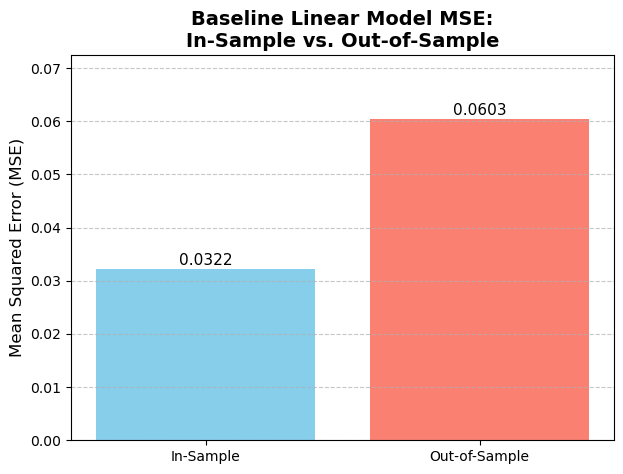

In [131]:
## Train & Test different linear models, print a summary table, and plot the train and test error

def train_test_linear(model_string, train, test):
    ## Run modified FF
    simple = ols(model_string, data = train).fit()
    print(simple.summary())

    test['y_hat'] = simple.predict(test)

    fin = test[['ret_exc_lead1m', 'y_hat']].dropna()

    in_out = ['In-Sample', 'Out-of-Sample']
    mses = [simple.mse_total, mse(fin['ret_exc_lead1m'], fin['y_hat'])]

    plt.figure(figsize=(7, 5))
    bars = plt.bar(in_out, mses, color=['skyblue', 'salmon'])

    # Add labels above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.0002, f'{yval:.4f}', ha='center', va='bottom', fontsize=11)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.title('Baseline Linear Model MSE:\nIn-Sample vs. Out-of-Sample', fontsize=14, fontweight='bold')
    plt.ylim(0, yval*1.2)
    plt.show()
    #plt.savefig('baseline_mse.png')
    return simple

baseline_model = train_test_linear("ret_exc_lead1m ~ me + be_me + ope_be + at_gr1 + ret_3_1", train, test)

                            OLS Regression Results                            
Dep. Variable:         ret_exc_lead1m   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     246.6
Date:                Wed, 19 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:11:30   Log-Likelihood:             3.1515e+05
No. Observations:             1048186   AIC:                        -6.303e+05
Df Residuals:                 1048175   BIC:                        -6.301e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0132      0.001     -9.467      0.0

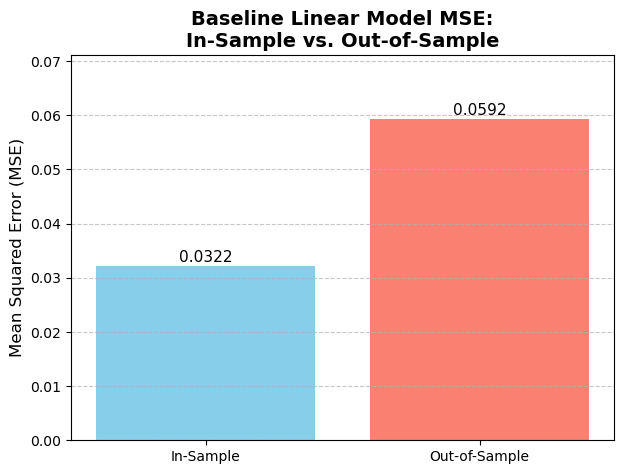

In [132]:
baseline_macro = train_test_linear("ret_exc_lead1m ~ me + be_me + ope_be + at_gr1 + ret_3_1 + FEDFUNDS + T10Y2Y + BAA10Y + VIXCLS + INDPRO", train, test)

In [ ]:
## This one way overfits
# train_test_linear("ret_exc_lead1m ~ me*FEDFUNDS + me*T10Y2Y + me*BAA10Y + me*VIXCLS + me*INDPRO +" \
#     "be_me*FEDFUNDS +  be_me*T10Y2Y + be_me*BAA10Y + be_me*VIXCLS + be_me*INDPRO +" \
#     "ope_be*FEDFUNDS +  ope_be*T10Y2Y + ope_be*BAA10Y + ope_be*VIXCLS + ope_be*INDPRO +" \
#     "at_gr1*FEDFUNDS +  at_gr1*T10Y2Y + at_gr1*BAA10Y + at_gr1*VIXCLS + at_gr1*INDPRO +" \
#     "ret_3_1*FEDFUNDS +  ret_3_1*T10Y2Y + ret_3_1*BAA10Y + ret_3_1*VIXCLS + ret_3_1*INDPRO", train, test)

In [ ]:
## Now what we do is re-calculate the model each time step, 
#     go long the stocks with the highest expected return and short the stocks with the lowest (top 10% and lowest 10% respectively).
#     report the model MSE, realized MSE, and the return of this strategy\


In [11]:
pd.set_option('mode.chained_assignment', None) 

In [ ]:
##
def make_ports(model_string):
        
    data_full['date'] = pd.to_datetime(data_full['date'])
    step_forward_dates = data_full['date'].sort_values().unique()[120:]

    results_dataframe = pd.DataFrame(columns=['date', 'train_mse', 'test_mse', 'ls_return'])

    for d in step_forward_dates:
        #d_minus_10 = d - relativedelta(years=10)

        #train_d = data_full[(data_full['date']>=d_minus_10) & (data_full['date']<d)]
        train_d = data_full[(data_full['date']<d)]
        test_d = data_full[data_full['date']==d]
        baseline = ols(model_string, data = train_d).fit()
        
        test_d['y_hat'] = baseline.predict(exog = test_d)

        fin = test_d[['ret_exc_lead1m', 'y_hat']].dropna()
        
        fin['top_decile'] = fin['y_hat'] > fin['y_hat'].quantile(0.9)
        fin['bot_decile'] = fin['y_hat'] < fin['y_hat'].quantile(0.1)

        ls_return = fin[fin['top_decile']]['ret_exc_lead1m'].mean() - fin[fin['bot_decile']]['ret_exc_lead1m'].mean()

        results_dataframe.loc[len(results_dataframe)] = [d, baseline.mse_resid, mse(fin['ret_exc_lead1m'], fin['y_hat']), ls_return]
        
    results_dataframe['cum_ret'] = (1 + results_dataframe['ls_return']).cumprod() - 1
    results_dataframe['date'] = pd.to_datetime(results_dataframe['date'])
    FF_portfolios['date'] = pd.to_datetime(FF_portfolios['date'])

    FF_port_sub = FF_portfolios[FF_portfolios['date'].isin(results_dataframe['date'])]
    FF_port_sub['mkt_cumulative'] = (1 + FF_port_sub['Mkt-RF']/100).cumprod() - 1

    fig, axes = plt.subplots(3, figsize=(10, 8), sharex=False)
    axes[0].plot(results_dataframe['date'], results_dataframe['train_mse'], color = 'blue')
    axes[0].set_ylabel('Train MSE')
    axes[1].plot(results_dataframe['date'], results_dataframe['test_mse'], color = 'orange')
    axes[1].set_ylabel('Test MSE')
    axes[2].plot(results_dataframe['date'], results_dataframe['cum_ret']*100, color = 'black')
    axes[2].plot(FF_port_sub['date'], FF_port_sub['mkt_cumulative']*100, color = 'green')
    axes[2].set_ylabel('Cumulative Return (%)')

    fig.autofmt_xdate()
    fig.suptitle('Baseline Linear Model Performance', fontsize=16)
    plt.show()
    
    print(f"Model SR: {results_dataframe['ls_return'].mean()/results_dataframe['ls_return'].std()}")
    print(f"Market SR: {FF_port_sub['Mkt-RF'].mean()/FF_port_sub['Mkt-RF'].std()}")
    return FF_port_sub


In [68]:
baseline_ports = make_ports("ret_exc_lead1m ~ me + be_me + ope_be + at_gr1 + ret_3_1")

KeyboardInterrupt: 

c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\biorio\AppData\Local\anaconda3\en

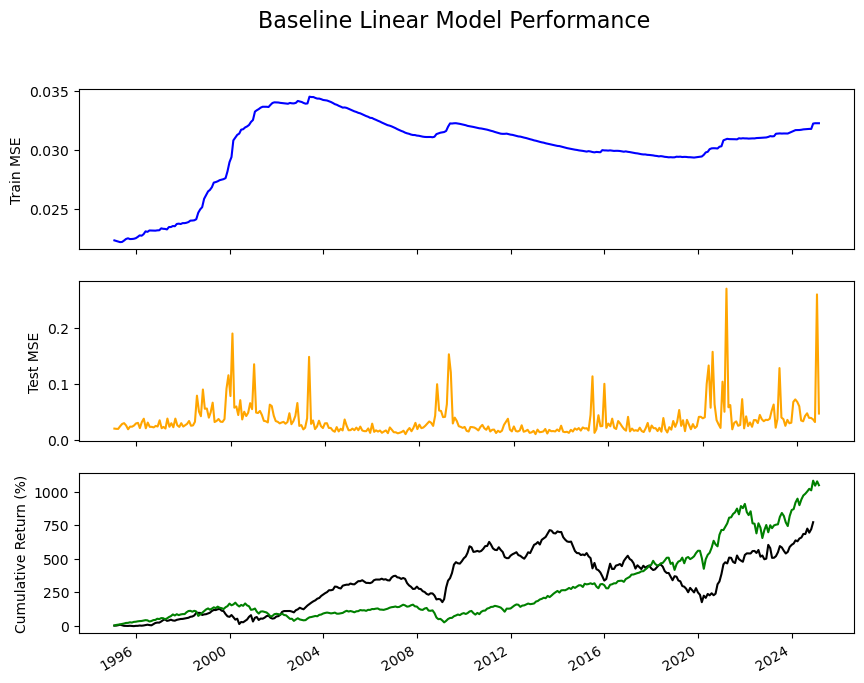

Model SR: 0.13547959398294915
Market SR: 0.1726885374217898


In [64]:
macro_results_dataframe = make_ports("ret_exc_lead1m ~ me + be_me + ope_be + at_gr1 + ret_3_1 + FEDFUNDS + T10Y2Y + BAA10Y + VIXCLS + INDPRO")

In [134]:
## This one way overfits

# macro_interaction_results_dataframe = make_ports("ret_exc_lead1m ~ me*FEDFUNDS + me*T10Y2Y + me*BAA10Y + me*VIXCLS + me*INDPRO +" \
#     "be_me*FEDFUNDS +  be_me*T10Y2Y + be_me*BAA10Y + be_me*VIXCLS + be_me*INDPRO +" \
#     "ope_be*FEDFUNDS +  ope_be*T10Y2Y + ope_be*BAA10Y + ope_be*VIXCLS + ope_be*INDPRO +" \
#     "at_gr1*FEDFUNDS +  at_gr1*T10Y2Y + at_gr1*BAA10Y + at_gr1*VIXCLS + at_gr1*INDPRO +" \
#     "ret_3_1*FEDFUNDS +  ret_3_1*T10Y2Y + ret_3_1*BAA10Y + ret_3_1*VIXCLS + ret_3_1*INDPRO")

In [77]:
## Now we see if differences when conditioning on macro variables has some economic meaning

data_full['baseline_y_hat'] = baseline_model.predict(exog = data_full)
data_full['baseline_macro_y_hat'] = baseline_macro.predict(exog = data_full)
data_full['y_hat_diff'] = data_full['baseline_macro_y_hat'] - data_full['baseline_y_hat']

## Take difference in expected return when conditioning on macro variable or not, 
# buy the ones with the largest increase, sell the ones with the largest decrease
# and see if the resulting portfolio explains the cross-section of returns 
# a future version of this should do this at each point in time to avoid lookahead bias but for now let's just try this...

data_full["decile"] = data_full.groupby("eom")["y_hat_diff"].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates="drop")
)

# Flag top and bottom decile
data_full["bot_decile"] = data_full["decile"] == 0
data_full["top_decile"] = data_full["decile"] == 9
data_full


,id,eom,excntry,gvkey,permno,prc_local,ret_exc,ret_exc_lead1m,me,be_me,...,T10Y2Y,BAA10Y,VIXCLS,INDPRO,baseline_y_hat,baseline_macro_y_hat,y_hat_diff,decile,bot_decile,top_decile
0,10000.0,1986-01-31,USA,13007.0,10000.0,4.375000,NaN,-0.262439,16.100000,NaN,...,1.09,2.29,NaN,0.009907,NaN,NaN,NaN,NaN,False,False
1,10000.0,1986-02-28,USA,13007.0,10000.0,3.250000,-0.262439,0.359422,11.960000,NaN,...,0.42,2.49,NaN,0.005239,NaN,NaN,NaN,NaN,False,False
2,10000.0,1986-03-31,USA,13007.0,10000.0,4.437500,0.359422,-0.103933,16.330000,NaN,...,0.47,2.92,NaN,-0.006863,NaN,NaN,NaN,NaN,False,False
3,10000.0,1986-04-30,USA,13007.0,10000.0,4.000000,-0.103933,-0.227590,15.172000,NaN,...,0.55,2.78,NaN,-0.007068,NaN,NaN,NaN,NaN,False,False
4,10000.0,1986-05-31,USA,13007.0,10000.0,3.109375,-0.227590,-0.010271,11.793859,0.058420,...,0.69,2.36,NaN,0.001134,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784833,135628901.0,2024-01-31,USA,356289.0,NaN,6.355000,NaN,NaN,170.676235,0.082321,...,-0.28,1.61,14.35,-0.002487,NaN,NaN,NaN,NaN,False,False
2784834,135628901.0,2024-02-29,USA,356289.0,NaN,5.000000,NaN,NaN,134.285000,0.104630,...,-0.39,1.55,13.40,-0.011185,NaN,NaN,NaN,NaN,False,False
2784835,135628901.0,2024-03-31,USA,356289.0,NaN,5.290000,NaN,NaN,143.549440,0.097878,...,-0.39,1.50,13.01,0.012255,NaN,NaN,NaN,NaN,False,False
2784836,135628901.0,2025-01-31,USA,356289.0,NaN,2.720000,NaN,NaN,84.325440,0.536583,...,0.36,1.45,16.43,0.010735,NaN,NaN,NaN,NaN,False,False


In [ ]:
##
top_dec_ret = data_full[data_full['top_decile']].groupby('eom',as_index=False)['ret_exc'].mean() 
bot_dec_ret = data_full[data_full['bot_decile']].groupby('eom',as_index=False)['ret_exc'].mean()
combined = top_dec_ret.merge(bot_dec_ret, on='eom')
combined['macro_condition_factor'] = combined['ret_exc_x'] - combined['ret_exc_y']
combined

plt.plot(combined['eom'], combined['macro_condition_factor'])
plt.show()

,eom,ret_exc_x,ret_exc_y,macro_condition_factor
0,1990-01-31,-0.067460,-0.081559,0.014099
1,1990-02-28,0.047049,-0.017241,0.064290
2,1990-03-31,0.069329,-0.003056,0.072385
3,1990-04-30,0.012543,-0.057370,0.069913
4,1990-05-31,0.110564,-0.001905,0.112469
...,...,...,...,...
416,2024-09-30,0.026685,0.016414,0.010271
417,2024-10-31,0.057912,-0.047499,0.105412
418,2024-11-30,0.195231,0.020342,0.174889
419,2024-12-31,0.057573,-0.045328,0.102901


In [101]:
## Uhh - let's just remove this one for now
combined.sort_values('macro_condition_factor')


,eom,ret_exc_x,ret_exc_y,macro_condition_factor
301,2015-02-28,0.070113,16.989591,-16.919478
132,2001-01-31,0.014101,0.365457,-0.351356
300,2015-01-31,-0.001551,0.201510,-0.203061
123,2000-04-30,-0.227386,-0.077788,-0.149597
122,2000-03-31,-0.160835,-0.020926,-0.139909
...,...,...,...,...
118,1999-11-30,0.248599,0.024557,0.224043
372,2021-01-31,0.281567,0.026102,0.255465
119,1999-12-31,0.355944,-0.002947,0.358891
121,2000-02-29,0.533508,-0.045500,0.579008


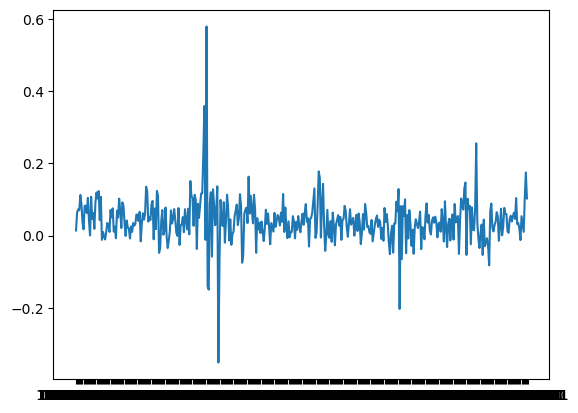

In [99]:
combined = combined[combined['eom'] != '2015-02-28']

plt.plot(combined['eom'], combined['macro_condition_factor'])
plt.show()

In [ ]:
## now to really test this we need to run this regression for every stock, and run a regression of the betas on the return of the stocks at each point in time (Fama Macbeth)
# https://en.wikipedia.org/wiki/Fama%E2%80%93MacBeth_regression
# I'll do this at some point
last_df = data_full[['date','eom', 'ret_exc', 'ret_exc_lead1m']][data_full['id']==10002.0].merge(combined, on = 'eom').merge(FF_portfolios, on='date')
last_df


final_model = ols('ret_exc ~ macro_condition_factor', last_df).fit()
print(final_model.summary())

final_model_w_ff = ols('ret_exc ~ mkt_exc + SMB + HML + RMW + CMA + macro_condition_factor', last_df).fit()
print(final_model_w_ff.summary())


                            OLS Regression Results                            
Dep. Variable:                ret_exc   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.263
Date:                Wed, 19 Nov 2025   Prob (F-statistic):             0.0399
Time:                        19:57:50   Log-Likelihood:                 217.11
No. Observations:                 277   AIC:                            -430.2
Df Residuals:                     275   BIC:                            -423.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0